In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords 
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
import string
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Data collection script

# // Self loading
# function loadMore() { 
#     setTimeout(function() {   // call setTimeout when function is called
#         var button = document.getElementById('load-more-trigger');  // fiind load button
#         var style = window.getComputedStyle(button);  // find style
#         visible = style.getPropertyValue('display');  // determine if there is more data to load
#         if (visible != 'none') {      // if button is available, load more
#             button.click();                  
#             loadMore();               // recursively check again for button
#         }
#         else {                        // else the job is done
#             console.log('Job\'s done!');
#         }                  
#     }, 3000);   // set delay to 3 seconds
# }
# loadMore();
#
# let reviews = document.getElementsByClassName('lister-item-content'); // create an HTML collection to hold review data
#
# review_data = [];   // create empty array to organize data
#
# for (let i = 0; i < reviews.length; i++) {    // loop through reviews to add it array
#     if (reviews[i].getElementsByClassName('rating-other-user-rating').length > 0) {   // don't add reviews without scores
#         review = {
#             'movie': document.getElementsByClassName('subnav_heading')[0].text,   // automatically read movie title
#             'user': reviews[i].getElementsByClassName('display-name-link')[0].innerText,
#             'date': reviews[i].getElementsByClassName('review-date')[0].innerText,
#             // Remove all line breaks and commas from user submitted text data
#             'title': reviews[i].getElementsByClassName('title')[0].innerText.trim().replace(/(\r\n|\n|\r)/gm, "").replace(/,/g, ''),
#             'review': reviews[i].getElementsByClassName('text show-more__control')[0].innerText.trim().replace(/(\r\n|\n|\r)/gm, "").replace(/,/g, ''),
#             'rating': reviews[i].getElementsByClassName('rating-other-user-rating')[0].innerText.slice(0,-3).trim()
#         }
#         review_data.push(review);   // add item to array
#     }
# }
#
# // Remove duplicates
# let unique_reviews = [...new Map(review_data.map((m) => [m.user, m])).values()]
#
# // Print reviews
# for(let i = 0; i < unique_reviews.length; i++) {
#     console.log(unique_reviews[i].movie + ',' + 
#                 unique_reviews[i].user + ',' + 
#                 unique_reviews[i].date + ',' + 
#                 unique_reviews[i].title + ',' + 
#                 unique_reviews[i].review + ',' +
#                 unique_reviews[i].rating + '\n')
# }

In [158]:
# Combine all reviews into a single dataframe
df = pd.DataFrame(columns=['movie', 'user', 'date', 'title', 'review', 'rating'])
for filename in glob.glob('./movie_reviews/*.csv'):
  df2 = pd.read_csv(filename, names=['movie', 'user', 'date', 'title', 'review', 'rating'])
  df = pd.concat([df,df2]).dropna() # drop rows with missing values

In [159]:
# Inspect data
df

,movie,user,date,title,review,rating
0,Date Movie,RogerBorg,25 February 2006,Not even Alyson Hannigan can pardon this turkey,I'd imagine that the main reason that people a...,1
1,Date Movie,ScottDMenzel,2 March 2006,Just when you thought Hollywood has reached an...,Date Movie is a movie that spoofs romantic com...,1
2,Date Movie,bdubstater4,20 February 2006,I'm writing this to save you,Its true. Everything you've read is true. This...,1
3,Date Movie,knightc6,22 February 2006,Wow something crappy this way comes,This won't be a long review as this movie does...,2
4,Date Movie,KingofMcDonalds,19 February 2006,I would pay someone to kick me in the balls fo...,This movie is one of the most horrible experie...,1
...,...,...,...,...,...,...
2130,Cats,thebergness,20 November 2020,Fool me once!,Come on! Cats would never do this! I for one o...,1
2131,Cats,mantkowiak-96279,6 December 2020,Not good,Ok for full disclosure so even though I enjoy ...,2
2132,Cats,barmyginge,2 January 2021,Don't do it!,I love musicals ... theatre or film ... and kn...,2
2133,Cats,elenhakso,30 January 2021,So so so bad,The CGI made me uncomfortable. I loved Cats th...,2


In [160]:
# Remove 'neutral' scores (ratings of 5 and 6)
df = df[(df.rating > 6) | (df.rating < 5)]

In [161]:
# Remove unnecessary data (keeping review and rating)
df = df.drop(['movie','user','date','title'], axis=1)

In [162]:
# Replace negative label with 1 and positive ratings with 0
df['rating'] = np.where(df['rating'] > 5, 0, 1)

In [163]:
df

,review,rating
0,I'd imagine that the main reason that people a...,1
1,Date Movie is a movie that spoofs romantic com...,1
2,Its true. Everything you've read is true. This...,1
3,This won't be a long review as this movie does...,1
4,This movie is one of the most horrible experie...,1
...,...,...
2130,Come on! Cats would never do this! I for one o...,1
2131,Ok for full disclosure so even though I enjoy ...,1
2132,I love musicals ... theatre or film ... and kn...,1
2133,The CGI made me uncomfortable. I loved Cats th...,1


In [164]:
# Clean the data, convert to lowercase
df['review'] = df['review'].str.lower()

# Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    text=re.sub(r'[^a-zA-z0-9\s]','',text)
    return text

df['review'] = df['review'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

# Apply function on review column
df['review']=df['review'].apply(remove_special_characters)

# Inspect results
df

,review,rating
0,id imagine that the main reason that people ar...,1
1,date movie is a movie that spoofs romantic com...,1
2,its true everything youve read is true this re...,1
3,this wont be a long review as this movie doesn...,1
4,this movie is one of the most horrible experie...,1
...,...,...
2130,come on cats would never do this i for one own...,1
2131,ok for full disclosure so even though i enjoy ...,1
2132,i love musicals theatre or film and know cat...,1
2133,the cgi made me uncomfortable i loved cats the...,1


In [165]:
# Inspect positive and negative counts
df['rating'].value_counts()

1    12980
0     9080
Name: rating, dtype: int64

In [166]:
# Remove tags and links
tag = re.compile(r'<[^>]+>')

df['review'] = df['review'].apply(lambda x: tag.sub('', x)) # Remove HTML labels

df['review'] = df['review'].replace(r'http\S+', '', regex=True).replace(r'www.\S+', '', regex=True).replace(r'http\S+', '', regex=True).replace(r'"', '', regex=True)


In [167]:
df

,review,rating
0,id imagine that the main reason that people ar...,1
1,date movie is a movie that spoofs romantic com...,1
2,its true everything youve read is true this re...,1
3,this wont be a long review as this movie doesn...,1
4,this movie is one of the most horrible experie...,1
...,...,...
2130,come on cats would never do this i for one own...,1
2131,ok for full disclosure so even though i enjoy ...,1
2132,i love musicals theatre or film and know cat...,1
2133,the cgi made me uncomfortable i loved cats the...,1


In [168]:
# Perform tokenization and lemmanization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(review):
    return " ".join([lemmatizer.lemmatize(w, pos="v") for w in w_tokenizer.tokenize(review)])

df['review'] = df.review.apply(lemmatize_text).copy()

df

,review,rating
0,id imagine that the main reason that people be...,1
1,date movie be a movie that spoof romantic come...,1
2,its true everything youve read be true this re...,1
3,this wont be a long review as this movie doesn...,1
4,this movie be one of the most horrible experie...,1
...,...,...
2130,come on cat would never do this i for one own ...,1
2131,ok for full disclosure so even though i enjoy ...,1
2132,i love musicals theatre or film and know cat w...,1
2133,the cgi make me uncomfortable i love cat the m...,1


In [169]:
# Split dataset into train, text, and validation sets
x = pd.DataFrame(df, columns = ['review']) 
y = pd.DataFrame(df, columns = ['rating']) 

# Split dataset to train and test set
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Split train dataset to train and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print("Shape of x_train: ", X_train.shape)
print("Shape of y_train: ", Y_train.shape)
print("Shape of x_test:  ", X_test.shape)
print("Shape of y_test:  ", Y_test.shape)
print("Shape of x_val:  ", X_val.shape)
print("Shape of y_val:  ", Y_val.shape)

Shape of x_train:  (14118, 1)
Shape of y_train:  (14118, 1)
Shape of x_test:   (4412, 1)
Shape of y_test:   (4412, 1)
Shape of x_val:   (3530, 1)
Shape of y_val:   (3530, 1)


In [170]:
# Vectorize
from sklearn.feature_extraction.text import TfidfVectorizer

train = X_train['review'].tolist()
val = X_val['review'].to_list()
test = X_test['review'].tolist()
STOPWORDS = set(stopwords.words('english'))

# Use 1000 features to improve score without crashing memory
tfidf_vectorizer = TfidfVectorizer(max_features=1000, dtype=np.float32)

tfidfX_train = tfidf_vectorizer.fit_transform(train)
tfidfX_train = tfidfX_train.toarray()

tfidfX_val = tfidf_vectorizer.transform(val)
tfidfX_val = tfidfX_val.toarray()

tfidfX_test = tfidf_vectorizer.transform(test)
tfidfX_test = tfidfX_test.toarray()

print("TF-IDF train shape:", tfidfX_train.shape)
print("TF-IDF test shape:", tfidfX_test.shape)
print("TF-IDF val shape:", tfidfX_val.shape)

TF-IDF train shape: (14118, 1000)
TF-IDF test shape: (4412, 1000)
TF-IDF val shape: (3530, 1000)


In [171]:
# Convert X datasets to tensors.
tfidfX_train = torch.tensor(tfidfX_train)
tfidfX_val = torch.tensor(tfidfX_val)
tfidfX_test = torch.tensor(tfidfX_test)

In [172]:
# Convert Y labels to tensors with torch.squeeze.
Y_train = torch.squeeze(torch.from_numpy(Y_train.to_numpy()).float())
Y_val = torch.squeeze(torch.from_numpy(Y_val.to_numpy()).float())
Y_test = torch.squeeze(torch.from_numpy(Y_test.to_numpy()).float())

In [173]:
device = torch.device("cpu")

In [216]:
# Build model with 2 hidden layers
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        
        # Linear function 1
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1) 
        # self.dropout = nn.Dropout(0.3)
        # self.batch1 = nn.BatchNorm1d(hidden_dim)
        
        # Non-linearity 1
        self.relu_1 = nn.ReLU()

        # Linear function 2
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Non-linearity 2
        self.relu_2 = nn.ReLU()

        # Linear function 3
        self.layer_3 = nn.Linear(hidden_dim_2, output_dim)  

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)

        out = self.layer_2(out)
        out = self.relu_2(out)

        out = self.layer_3(out)

        return torch.sigmoid(out)

In [226]:
# Initialize model
# Dimensions of each layer and num of epochs.
input_dim = tfidfX_train.shape[1]
hidden_dim_1 = 512
hidden_dim_2 = 512
output_dim = 1
num_epochs = 20

# Define our first feed forward neural network.
first_model = FeedforwardNeuralNetModel(input_dim,hidden_dim_1,hidden_dim_2,output_dim)

# Define loss function.
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# Define as optimizer Adam.
optimizer = optim.Adam(first_model.parameters(),lr=0.1e-3,weight_decay=1e-3)

# Transfer all the computation to GPU (cuda device).
first_model.to(device)
criterion = criterion.to(device)

In [227]:
# This is a function that calculate the accuracy manually
def calculate_accuracy(y_true, y_pred):  
  y_pred = torch.round(y_pred)
  correct = (y_true == y_pred).float() 
  acc = correct.sum() / len(correct)
  return acc

batch_size = 256

# Split train dataset to mini batches
X_train_mini_batches = torch.split(tfidfX_train,batch_size)
Y_train_mini_batches = torch.split(Y_train,batch_size)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Start training
for epoch in range(num_epochs):
  epoch_loss = 0
  epoch_accuracy = 0
  validation_loss=0
  val_accuracy=0

  for X_train_mini_batch,Y_train_mini_batch in zip(X_train_mini_batches,Y_train_mini_batches):
    
    X_train_mini_batch = X_train_mini_batch.to(device)
    Y_train_mini_batch = Y_train_mini_batch.to(device)

    # Forward pass to get output
    train_prediction = first_model.forward(X_train_mini_batch.float())
    train_prediction = torch.squeeze(train_prediction)

    # Calculate Loss
    train_loss = criterion(train_prediction,Y_train_mini_batch)

    # Clearing up accumulated gradients
    optimizer.zero_grad()
    
    # Getting gradients
    train_loss.backward()

    # Updating parameters
    optimizer.step()

    # Add each mini batch's loss
    epoch_loss += train_loss.item()

    # Add each mini batch's accuracy
    epoch_accuracy += calculate_accuracy(Y_train_mini_batch,train_prediction)

  # For some epochs print loss and accucary of train and validation set.
  if epoch % 1 == 0:
    
    tfidfX_val = tfidfX_val.to(device)
    Y_val = Y_val.to(device)

    # Forward pass to get output
    val_prediction = first_model.forward(tfidfX_val.float())
    val_prediction = torch.squeeze(val_prediction)
    
    # Calculate Loss
    val_loss = criterion(val_prediction,Y_val)

    # Add each mini batch's loss
    validation_loss = val_loss.item()

    # Add each mini batch's accuracy
    val_accuracy = calculate_accuracy(Y_val,val_prediction)

    epoch_loss /= len(X_train_mini_batches)
    epoch_accuracy /= len(X_train_mini_batches)
    val_losses.append(validation_loss)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_accuracies.append(val_accuracy)

    print("Epoch:",epoch, "\n"
      "Train_loss:",round(epoch_loss,4), "Train Accuracy:",round(epoch_accuracy.item(),4), "\n"
      "Validation_loss:  ",round(validation_loss,4), "Validation Accuracy:  ",round(val_accuracy.item(),4), "\n")

Epoch: 0 
Train_loss: 0.6857 Train Accuracy: 0.5582 
Validation_loss:   0.6726 Validation Accuracy:   0.5824 

Epoch: 1 
Train_loss: 0.6492 Train Accuracy: 0.5887 
Validation_loss:   0.6156 Validation Accuracy:   0.6113 

Epoch: 2 
Train_loss: 0.5489 Train Accuracy: 0.7265 
Validation_loss:   0.4688 Validation Accuracy:   0.8116 

Epoch: 3 
Train_loss: 0.3981 Train Accuracy: 0.851 
Validation_loss:   0.3428 Validation Accuracy:   0.8663 

Epoch: 4 
Train_loss: 0.3131 Train Accuracy: 0.877 
Validation_loss:   0.2978 Validation Accuracy:   0.8776 

Epoch: 5 
Train_loss: 0.2827 Train Accuracy: 0.8888 
Validation_loss:   0.2825 Validation Accuracy:   0.8839 

Epoch: 6 
Train_loss: 0.2693 Train Accuracy: 0.8926 
Validation_loss:   0.2761 Validation Accuracy:   0.8836 

Epoch: 7 
Train_loss: 0.2617 Train Accuracy: 0.8949 
Validation_loss:   0.273 Validation Accuracy:   0.8847 

Epoch: 8 
Train_loss: 0.2568 Train Accuracy: 0.8974 
Validation_loss:   0.2715 Validation Accuracy:   0.8841 

Epoc

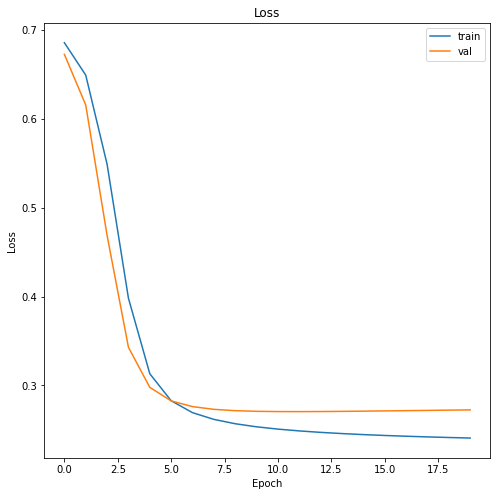

In [228]:
# Plot loss vs epochs
figure(figsize=(8,8)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

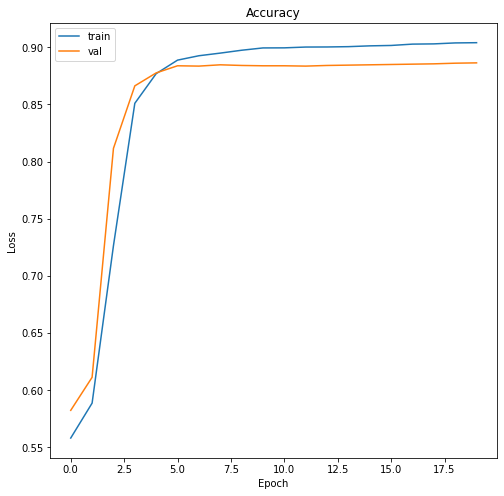

In [229]:
# Plot accuracy vs epochs
figure(figsize=(8,8)) 
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

In [212]:
tfidfX_test = tfidfX_test.to(device)
Y_test = Y_test.to(device)

# Forward pass to get output
test_prediction = first_model.forward(tfidfX_test.float())
test_prediction = torch.squeeze(test_prediction)

# Calculate accuracy on test set
test_accuracy = calculate_accuracy(Y_test,test_prediction)

print("Test Accuracy:",round(test_accuracy.item(),4), "\n")

Test Accuracy: 0.8756 



In [210]:
# Show classification report
test_prediction = test_prediction.to(device)
test_prediction = test_prediction.ge(.5).view(-1).cpu()
Y_test = Y_test.cpu()

print(classification_report(Y_test,test_prediction))

              precision    recall  f1-score   support

         0.0       0.85      0.84      0.84      1780
         1.0       0.89      0.90      0.90      2632

    accuracy                           0.88      4412
   macro avg       0.87      0.87      0.87      4412
weighted avg       0.88      0.88      0.88      4412

